In [77]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
# plt.style.use('ggplot')
# % matplotlib inline

In [78]:
df = pd.read_csv('CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          685
Related - but not informative    268
Not related                      238
Not applicable                     9
Name: Informativeness, dtype: int64

In [79]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          622
Related - but not informative    257
Not related                      238
Name: Informativeness, dtype: int64

In [80]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative


In [81]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import preprocessor as p

emoji_re = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emojis = [regexp_tokenize(t, emoji_re) for t in df.TweetText]
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i] if t not in en_stop ]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative,#intern #us #tattoo #wisconsin #ohio #nc #pa #...
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @jack4ward : get fun every thursday @csinde...
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative,welcome newest studentathlete - reagan biechle...
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative,denver post : #colorado governor sign bill cre...
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative,"pretty sure i'm going live manitou spring , co..."


In [82]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [83]:
mnb_count_pp = MultinomialNB(1.2, False)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

from sklearn.cross_validation import cross_val_score, KFold 
from scipy.stats import sem 

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)  
    scores = cross_val_score(clf, X, y, cv=cv) 
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.80952381 0.89285714 0.70238095 0.85714286 0.88095238 0.80952381
 0.83333333 0.80722892 0.77108434 0.87951807]
Mean score: 0.824 (+/-0.018)
Accuracy for training: 0.968936678614
Accuracy for testing: 0.814285714286


In [84]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.86      0.74      0.80       137
       Related and informative       0.78      0.88      0.83       143

                   avg / total       0.82      0.81      0.81       280

Confusion Matrix:
[[102  35]
 [ 17 126]]


In [85]:
X_count_pp_test.shape

(280, 2772)

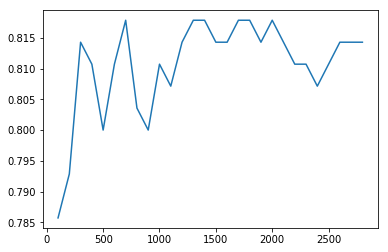

[0.7857142857142857, 0.7928571428571428, 0.8142857142857143, 0.8107142857142857, 0.8, 0.8107142857142857, 0.8178571428571428, 0.8035714285714286, 0.8, 0.8107142857142857, 0.8071428571428572, 0.8142857142857143, 0.8178571428571428, 0.8178571428571428, 0.8142857142857143, 0.8142857142857143, 0.8178571428571428, 0.8178571428571428, 0.8142857142857143, 0.8178571428571428, 0.8142857142857143, 0.8107142857142857, 0.8107142857142857, 0.8071428571428572, 0.8107142857142857, 0.8142857142857143, 0.8142857142857143, 0.8142857142857143]


In [86]:
k = range(100,2900,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(1.2, False)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

In [87]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative,#intern #us #tattoo #wisconsin #ohio #nc #pa #...
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @jack4ward : get in on the fun every thursd...
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative,welcome to our newest studentathlete - reagan ...
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative,denver post : #colorado governor sign bill cre...
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative,pretty sure i'm going to live in manitou sprin...


In [88]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
count_pp_vec = CountVectorizer(analyzer='word')
X_count_pp_train = count_pp_vec.fit_transform(X_train2)  
X_count_pp_test = count_pp_vec.transform(X_test2)

In [89]:
mnb_count_pp = MultinomialNB(1, False)  
mnb_count_pp.fit(X_count_pp_train, y_train2)

evaluate_cross_validation(mnb_count_pp, X_count_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_count_pp.score(X_count_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_count_pp.score(X_count_pp_test, y_test2))

[0.8452381  0.88095238 0.73809524 0.85714286 0.86904762 0.82142857
 0.88095238 0.78313253 0.77108434 0.90361446]
Mean score: 0.835 (+/-0.017)
Accuracy for training: 0.967741935484
Accuracy for testing: 0.825


In [90]:
y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_count_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.85      0.77      0.81       137
       Related and informative       0.80      0.87      0.84       143

                   avg / total       0.83      0.82      0.82       280

Confusion Matrix:
[[106  31]
 [ 18 125]]


In [91]:
X_count_pp_test.shape

(280, 2864)

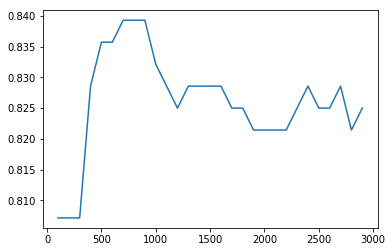

[0.8071428571428572, 0.8071428571428572, 0.8071428571428572, 0.8285714285714286, 0.8357142857142857, 0.8357142857142857, 0.8392857142857143, 0.8392857142857143, 0.8392857142857143, 0.8321428571428572, 0.8285714285714286, 0.825, 0.8285714285714286, 0.8285714285714286, 0.8285714285714286, 0.8285714285714286, 0.825, 0.825, 0.8214285714285714, 0.8214285714285714, 0.8214285714285714, 0.8214285714285714, 0.825, 0.8285714285714286, 0.825, 0.825, 0.8285714285714286, 0.8214285714285714, 0.825]


In [92]:
k = range(100,3000,100)
k_score = []
for i in k:  
    count_pp_vec = CountVectorizer(analyzer='word', max_features = i)  
    X_count_pp_train = count_pp_vec.fit_transform(X_train2)
    X_count_pp_test = count_pp_vec.transform(X_test2)
    mnb_count_pp = MultinomialNB(1, False)  
    mnb_count_pp.fit(X_count_pp_train, y_train2)
    score = mnb_count_pp.score(X_count_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### Test other data set

### Colorado floods

In [93]:
df = pd.read_csv('CrisisLexT26/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          768
Related - but not informative    157
Not related                       70
Not applicable                     5
Name: Informativeness, dtype: int64

In [94]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          691
Related - but not informative    156
Not related                       70
Name: Informativeness, dtype: int64

In [95]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,376843697943769088,#Longmont #CO The Tiny Tim Center is now #hiri...,Not labeled,Not labeled,Not related,Not related or not informative
1,378011169883037697,"RT @dlfluegge: Crazy Flooding in Boulder, Colo...",Media,Sympathy and support,Related - but not informative,Not related or not informative
2,378020179214491649,Here's the #boulderflood video that's circulat...,Outsiders,Other Useful Information,Related and informative,Related and informative
3,378026101588496385,RT @passantino: Video: Severe flooding hits ne...,Media,Other Useful Information,Related and informative,Related and informative
4,378029784204206080,"Crazy Flooding in Boulder, Colorado http://t.c...",Media,Other Useful Information,Related and informative,Related and informative


In [96]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,376843697943769088,#Longmont #CO The Tiny Tim Center is now #hiri...,Not labeled,Not labeled,Not related,Not related or not informative,#longmont #co the tiny tim center is now #hiri...
1,378011169883037697,"RT @dlfluegge: Crazy Flooding in Boulder, Colo...",Media,Sympathy and support,Related - but not informative,Not related or not informative,"rt @dlfluegge : crazy flooding in boulder , co..."
2,378020179214491649,Here's the #boulderflood video that's circulat...,Outsiders,Other Useful Information,Related and informative,Related and informative,here's the #boulderflood video that's circulat...
3,378026101588496385,RT @passantino: Video: Severe flooding hits ne...,Media,Other Useful Information,Related and informative,Related and informative,rt @passantino : video : severe flooding hit n...
4,378029784204206080,"Crazy Flooding in Boulder, Colorado http://t.c...",Media,Other Useful Information,Related and informative,Related and informative,"crazy flooding in boulder , colorado"


In [106]:
X_count_pp_test = count_pp_vec.transform(df.ProcessedText)

y_count_pp_predict = mnb_count_pp.predict(X_count_pp_test)

print "Classification Report:" 
print metrics.classification_report(df.label,y_count_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(df.label,y_count_pp_predict)
print "Accuracy:"
print metrics.accuracy_score(df.label,y_count_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.42      0.64      0.51       226
       Related and informative       0.86      0.72      0.78       691

                   avg / total       0.75      0.70      0.71       917

Confusion Matrix:
[[144  82]
 [196 495]]
Accuracy:
0.6968375136314068
